In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import src.data_utils as data_utils
import src.tree_build as dt_tree
import src.heurestics as dt_heur
import src.tree_utils as tree_utils
import src.dt_testing_utils as dt_testing
import src.tree_pruning as tree_pruning

from pprint import pprint
import numpy as np
import pandas as pd
from sklearn.utils import resample
#TODO - Add cancer

## Utils

In [3]:
def print_tree_informations(tree, training_data, testing_data):
    accuracy_testing = tree_utils.tree_accuracy(testing_data, tree)
    accuracy_training = tree_utils.tree_accuracy(training_data, tree)
    levels = tree_utils.number_of_levels(tree)
    leafs = tree_utils.number_of_leafs(tree)
    print("Accuracy for: testing {0:.2f}% | training {1:.2f}% | levels {2} | leafs {3}".format(accuracy_testing, accuracy_training,levels, leafs))

In [4]:
#heuristics
def train_and_prune_tree(heurestic, training_data, testing_data, validation_data):
    print("Before Pruning - heuristic = {0}".format(heurestic.__name__))
    trained_tree = dt_tree.build_tree_generic(heurestic, training_data)
    print_tree_informations(trained_tree, training_data, testing_data)
#     pprint(trained_tree)
    print("After Pruning:")
    pruned_trained_tree = tree_pruning.reduced_error_pruning(trained_tree, validation_data)
    print_tree_informations(pruned_trained_tree, training_data, testing_data)
    print('\n')
#     pprint(pruned_trained_tree)

In [5]:
default_heuristics = [dt_heur.gini_impurity_weighted, dt_heur.info_gain, dt_heur.information_gain_ratio,
                      dt_heur.distance_measure, dt_heur.j_measure, dt_heur.weight_of_evidence,
                      dt_heur.gini_pri, dt_heur.relief, dt_heur.relevance, dt_heur.mdl_simple]

def train_tree_for_different_heuristics(training_data, testing_data, validation_data, heuristics = default_heuristics):
    for heuristic in heuristics:
        train_and_prune_tree(heuristic, training_data, testing_data, validation_data)

# Car dataset

## Dataset preparation

In [6]:
car_dataset_path = 'data/car.data'
car_dataset_labels = ['buying','maint','doors','persons','lug_boot','safety','CLASS']
car_dataset = data_utils.preapare_dataset(car_dataset_path, car_dataset_labels)
# car_dataset.head()
car_dataset

,buying,maint,doors,persons,lug_boot,safety,CLASS
0,low,high,2,more,big,high,vgood
1,low,vhigh,2,2,big,low,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,med,3,4,big,med,acc
4,high,low,2,more,big,low,unacc
...,...,...,...,...,...,...,...
1723,med,med,3,4,big,low,unacc
1724,vhigh,high,5more,4,med,high,unacc
1725,vhigh,med,4,more,big,med,acc
1726,vhigh,low,5more,2,small,med,unacc


### Dataset 70%

unacc    849
acc      263
vgood     49
good      48
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

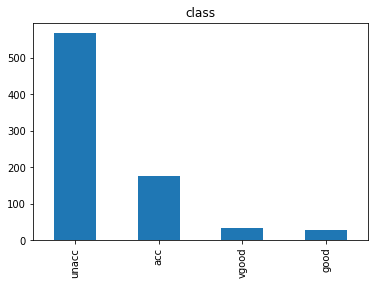

In [7]:
car_set_for_training70, car_testing70 = data_utils.data_split(car_dataset, 70)
car_training70, car_validation70 = data_utils.split_training_data_for_pruning(car_set_for_training70)
print(car_set_for_training70['CLASS'].value_counts())
car_training70['CLASS'].value_counts().plot(kind='bar', title='class')

In [8]:
car_training70

,buying,maint,doors,persons,lug_boot,safety,CLASS
0,low,high,2,more,big,high,vgood
1,low,vhigh,2,2,big,low,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,med,3,4,big,med,acc
4,high,low,2,more,big,low,unacc
...,...,...,...,...,...,...,...
800,low,low,4,4,small,low,unacc
801,low,low,5more,2,big,high,unacc
802,med,low,5more,4,big,high,vgood
803,high,vhigh,2,more,med,high,unacc


176


<AxesSubplot:title={'center':'class'}>

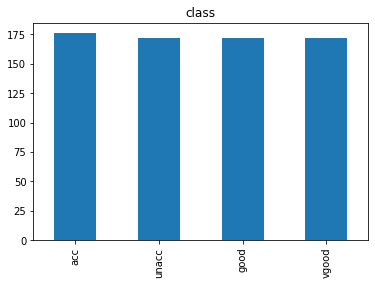

In [9]:
#Target for all 174
resampling_car70 = car_training70.copy()
unacc_part70 = resampling_car70[resampling_car70['CLASS'] == 'unacc']
acc_part70 = resampling_car70[resampling_car70['CLASS'] == 'acc'] 
print(len(acc_part70))
vgood_part70 = resampling_car70[resampling_car70['CLASS'] == 'vgood'] 
good_part70 = resampling_car70[resampling_car70['CLASS'] == 'good'] 


unacc_downsample70 = resample(unacc_part70, 
                                 replace=False,     
                                 n_samples=172)

vgood_part_upsampled70 = resample(vgood_part70, 
                                 replace=True,     
                                 n_samples=172)
good_part_upsampled70 = resample(good_part70, 
                                 replace=True,     
                                 n_samples=172)

# Combine majority class with upsamplet minority class
balanced_car_training70 = pd.concat([unacc_downsample70, acc_part70, vgood_part_upsampled70, good_part_upsampled70])
balanced_car_training70 = balanced_car_training70.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_car_training70 = balanced_car_training70.sample(frac=1).reset_index(drop=True)

car_training70 = balanced_car_training70.copy()
car_training70['CLASS'].value_counts().plot(kind='bar', title='class')

In [10]:
car_training70.head()

,buying,maint,doors,persons,lug_boot,safety,CLASS
0,low,low,5more,4,big,med,good
1,low,high,5more,4,med,high,vgood
2,vhigh,high,3,4,med,med,unacc
3,low,high,4,more,small,high,acc
4,med,vhigh,3,4,small,med,unacc


### Dataset 80%

unacc    971
acc      302
good      56
vgood     53
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

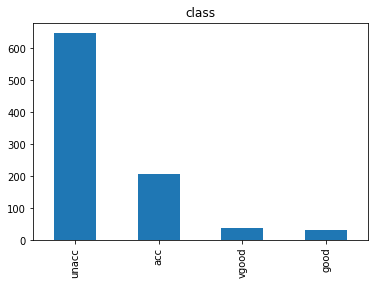

In [11]:
car_set_for_training80, car_testing80 = data_utils.data_split(car_dataset, 80)
car_training80, car_validation80 = data_utils.split_training_data_for_pruning(car_set_for_training80)
print(car_set_for_training80['CLASS'].value_counts())
car_training80['CLASS'].value_counts().plot(kind='bar', title='class')

In [12]:
car_training80

,buying,maint,doors,persons,lug_boot,safety,CLASS
0,low,high,2,more,big,high,vgood
1,low,vhigh,2,2,big,low,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,med,3,4,big,med,acc
4,high,low,2,more,big,low,unacc
...,...,...,...,...,...,...,...
916,med,med,2,4,med,low,unacc
917,high,vhigh,4,4,small,low,unacc
918,vhigh,med,4,4,big,high,acc
919,vhigh,high,2,2,med,low,unacc


206


<AxesSubplot:title={'center':'class'}>

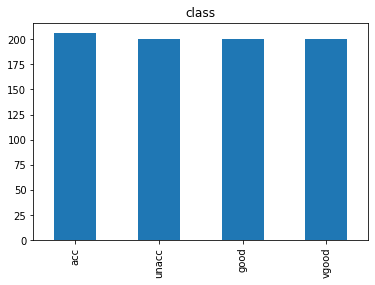

In [13]:
#Target for all 318
resampling_car80 = car_training80.copy()
unacc_part80 = resampling_car80[resampling_car80['CLASS'] == 'unacc']
acc_part80 = resampling_car80[resampling_car80['CLASS'] == 'acc'] 
print(len(acc_part80))
vgood_part80 = resampling_car80[resampling_car80['CLASS'] == 'vgood'] 
good_part80 = resampling_car80[resampling_car80['CLASS'] == 'good'] 


unacc_downsample80 = resample(unacc_part80, 
                                 replace=False,     
                                 n_samples=200)

vgood_part_upsampled80 = resample(vgood_part80, 
                                 replace=True,     
                                 n_samples=200)
good_part_upsampled80 = resample(good_part80, 
                                 replace=True,     
                                 n_samples=200)

# Combine majority class with upsamplet minority class
balanced_car_training80 = pd.concat([unacc_downsample80, acc_part80, vgood_part_upsampled80, good_part_upsampled80])
balanced_car_training80 = balanced_car_training80.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_car_training80 = balanced_car_training80.sample(frac=1).reset_index(drop=True)

car_training80 = balanced_car_training80.copy()
car_training80['CLASS'].value_counts().plot(kind='bar', title='class')

In [14]:
car_training80.head()

,buying,maint,doors,persons,lug_boot,safety,CLASS
0,low,high,4,more,small,high,acc
1,med,med,5more,more,med,high,vgood
2,low,vhigh,2,2,small,low,unacc
3,vhigh,low,3,4,med,high,acc
4,low,low,5more,more,big,high,vgood


## Model Training

### Dataset 90%

unacc    1091
acc       345
vgood      60
good       59
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

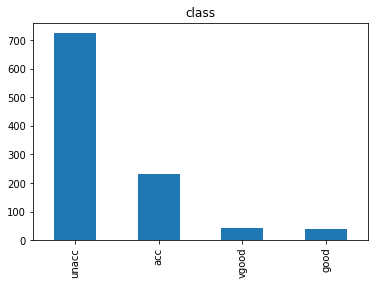

In [15]:
car_set_for_training90, car_testing90 = data_utils.data_split(car_dataset, 90)
car_training90, car_validation90 = data_utils.split_training_data_for_pruning(car_set_for_training90)
print(car_set_for_training90['CLASS'].value_counts())
car_training90['CLASS'].value_counts().plot(kind='bar', title='class')

In [16]:
# car_training90

230


<AxesSubplot:title={'center':'class'}>

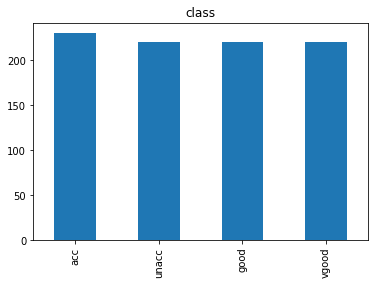

In [17]:
#Target for all 352?
resampling_car90 = car_training90.copy()
unacc_part90 = resampling_car90[resampling_car90['CLASS'] == 'unacc']
acc_part90 = resampling_car90[resampling_car90['CLASS'] == 'acc']
print(len(acc_part90))
vgood_part90 = resampling_car90[resampling_car90['CLASS'] == 'vgood'] 
good_part90 = resampling_car90[resampling_car90['CLASS'] == 'good'] 


unacc_downsample90 = resample(unacc_part90, 
                                 replace=False,     
                                 n_samples=220)

vgood_part_upsampled90 = resample(vgood_part90, 
                                 replace=True,     
                                 n_samples=220)
good_part_upsampled90 = resample(good_part90, 
                                 replace=True,     
                                 n_samples=220)

# Combine majority class with upsamplet minority class
balanced_car_training90 = pd.concat([unacc_downsample90, acc_part90, vgood_part_upsampled90, good_part_upsampled90])
balanced_car_training90 = balanced_car_training90.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_car_training90 = balanced_car_training90.sample(frac=1).reset_index(drop=True)

car_training90 = balanced_car_training90.copy()
car_training90['CLASS'].value_counts().plot(kind='bar', title='class')

In [18]:
car_training90

,buying,maint,doors,persons,lug_boot,safety,CLASS
0,med,med,5more,4,big,high,vgood
1,low,med,2,more,big,med,good
2,low,high,5more,more,big,high,vgood
3,med,high,3,4,small,high,acc
4,low,low,2,more,big,high,vgood
...,...,...,...,...,...,...,...
885,high,vhigh,2,4,small,med,unacc
886,high,high,5more,4,med,med,acc
887,vhigh,vhigh,2,4,big,high,unacc
888,vhigh,high,3,2,big,high,unacc


In [19]:
# trained_tree_car = dt_tree.build_tree_generic(dt_heur.information_gain_ratio, car_training)

In [20]:
# # print(trained_tree_car)
# pprint(trained_tree_car)

In [21]:
train_tree_for_different_heuristics(car_training70, car_testing70, car_validation70)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 51.06% | training 73.12% | levels 10 | leafs 30
After Pruning:
Accuracy for: testing 66.47% | training 53.47% | levels 10 | leafs 9


Before Pruning - heuristic = info_gain
Accuracy for: testing 53.18% | training 74.71% | levels 10 | leafs 29
After Pruning:
Accuracy for: testing 66.09% | training 59.10% | levels 10 | leafs 16


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 46.05% | training 70.52% | levels 10 | leafs 30
After Pruning:
Accuracy for: testing 64.35% | training 57.80% | levels 10 | leafs 16


Before Pruning - heuristic = distance_measure
Accuracy for: testing 38.54% | training 55.06% | levels 10 | leafs 31
After Pruning:
Accuracy for: testing 58.77% | training 32.37% | levels 10 | leafs 10


Before Pruning - heuristic = j_measure
Accuracy for: testing 54.72% | training 75.29% | levels 10 | leafs 29
After Pruning:
Accuracy for: testing 67.63% | training 59.68% | levels 10 |

In [22]:
train_tree_for_different_heuristics(car_training80, car_testing80, car_validation80)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 55.78% | training 72.21% | levels 10 | leafs 30
After Pruning:
Accuracy for: testing 67.34% | training 60.05% | levels 10 | leafs 15


Before Pruning - heuristic = info_gain
Accuracy for: testing 46.53% | training 64.64% | levels 10 | leafs 31
After Pruning:
Accuracy for: testing 62.43% | training 53.97% | levels 10 | leafs 16


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 54.34% | training 67.25% | levels 10 | leafs 31
After Pruning:
Accuracy for: testing 63.87% | training 55.58% | levels 10 | leafs 17


Before Pruning - heuristic = distance_measure
Accuracy for: testing 52.89% | training 54.47% | levels 10 | leafs 32
After Pruning:
Accuracy for: testing 63.29% | training 32.51% | levels 10 | leafs 9


Before Pruning - heuristic = j_measure
Accuracy for: testing 50.58% | training 65.88% | levels 10 | leafs 30
After Pruning:
Accuracy for: testing 62.43% | training 53.97% | levels 10 |

In [23]:
train_tree_for_different_heuristics(car_training90, car_testing90, car_validation90)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 48.55% | training 66.97% | levels 10 | leafs 32
After Pruning:
Accuracy for: testing 64.16% | training 53.82% | levels 10 | leafs 9


Before Pruning - heuristic = info_gain
Accuracy for: testing 49.71% | training 68.99% | levels 10 | leafs 32
After Pruning:
Accuracy for: testing 63.01% | training 55.17% | levels 10 | leafs 10


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 39.31% | training 66.07% | levels 10 | leafs 31
After Pruning:
Accuracy for: testing 57.80% | training 54.83% | levels 10 | leafs 20


Before Pruning - heuristic = distance_measure
Accuracy for: testing 42.77% | training 55.96% | levels 10 | leafs 31
After Pruning:
Accuracy for: testing 61.85% | training 32.02% | levels 10 | leafs 14


Before Pruning - heuristic = j_measure
Accuracy for: testing 46.82% | training 66.52% | levels 10 | leafs 32
After Pruning:
Accuracy for: testing 61.85% | training 53.71% | levels 10 |

# Cancer Dataset

# Dataset preparation

In [24]:
cancer_dataset_path = 'data/breast-cancer.data'
cancer_dataset_labels = ['CLASS','age','menopause','tumor-size','inv-nodes','node-caps','deg-malig','breast', 'breast-quad', 'irradiat']
cancer_dataset = data_utils.preapare_dataset(cancer_dataset_path, cancer_dataset_labels)
cancer_dataset = cancer_dataset[['age','menopause','tumor-size','inv-nodes', 'node-caps','deg-malig','breast', 'breast-quad', 'irradiat', 'CLASS']]
# cancer_dataset.head()
cancer_dataset

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,CLASS
0,30-39,premeno,30-34,0-2,no,2,left,left_up,no,recurrence-events
1,50-59,ge40,20-24,0-2,no,2,right,central,no,recurrence-events
2,40-49,ge40,20-24,0-2,no,3,left,left_low,no,no-recurrence-events
3,40-49,premeno,15-19,0-2,no,2,left,left_low,no,no-recurrence-events
4,40-49,premeno,25-29,9-11,yes,3,right,left_up,no,recurrence-events
...,...,...,...,...,...,...,...,...,...,...
281,70-79,ge40,40-44,0-2,no,1,right,left_up,no,no-recurrence-events
282,50-59,premeno,25-29,3-5,no,2,right,left_up,yes,no-recurrence-events
283,60-69,ge40,25-29,3-5,no,2,right,right_up,no,recurrence-events
284,40-49,premeno,20-24,0-2,no,3,right,left_low,yes,no-recurrence-events


### Cancer 70%

no-recurrence-events    92
recurrence-events       41
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

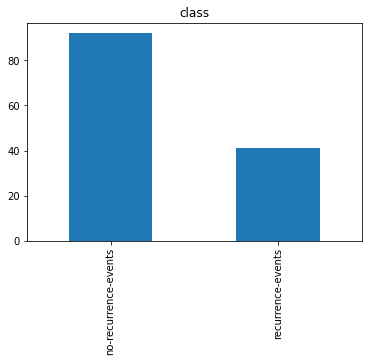

In [25]:
cancer_set_for_training70, cancer_testing70 = data_utils.data_split(cancer_dataset, 70)
cancer_training70, cancer_validation70 = data_utils.split_training_data_for_pruning(cancer_set_for_training70)
print(cancer_training70['CLASS'].value_counts())
cancer_training70['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

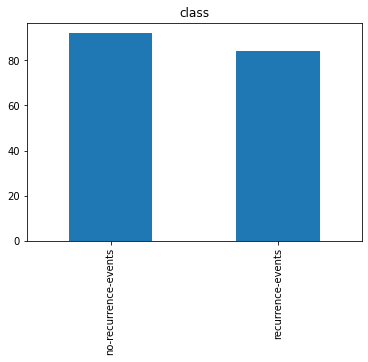

In [26]:
#Target for all 174
resampling_cancer70 = cancer_training70.copy()
recurrence_events_part70 = resampling_cancer70[resampling_cancer70['CLASS'] == 'recurrence-events']
no_recurrence_events_part70 = resampling_cancer70[resampling_cancer70['CLASS'] == 'no-recurrence-events'] 

recurrence_events_part_upsampled70 = resample(recurrence_events_part70, 
                                 replace=True,     
                                 n_samples=84)

# Combine majority class with upsamplet minority class
balanced_cnacer_training70 = pd.concat([recurrence_events_part_upsampled70, no_recurrence_events_part70])
balanced_cnacer_training70 = balanced_cnacer_training70.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_cnacer_training70 = balanced_cnacer_training70.sample(frac=1).reset_index(drop=True)

cancer_training70 = balanced_cnacer_training70.copy()
cancer_training70['CLASS'].value_counts().plot(kind='bar', title='class')

### Cancer 80%

no-recurrence-events    103
recurrence-events        48
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

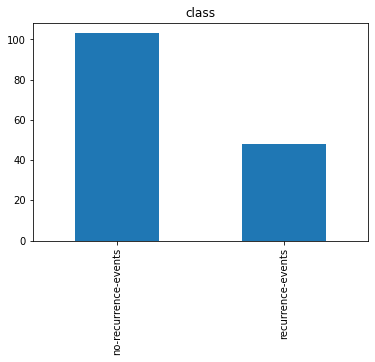

In [27]:
cancer_set_for_training80, cancer_testing80 = data_utils.data_split(cancer_dataset, 80)
cancer_training80, cancer_validation80 = data_utils.split_training_data_for_pruning(cancer_set_for_training80)
print(cancer_training80['CLASS'].value_counts())
cancer_training80['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

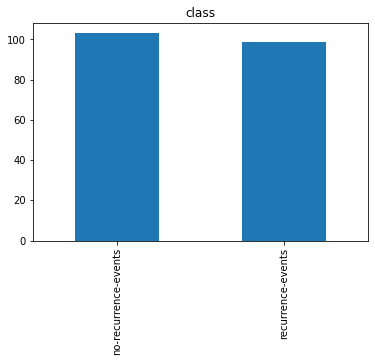

In [28]:
#Target for all 174
resampling_cancer80 = cancer_training80.copy()
recurrence_events_part80 = resampling_cancer80[resampling_cancer80['CLASS'] == 'recurrence-events']
no_recurrence_events_part80 = resampling_cancer80[resampling_cancer80['CLASS'] == 'no-recurrence-events'] 

recurrence_events_part_upsampled80 = resample(recurrence_events_part80, 
                                 replace=True,     
                                 n_samples=99)

# Combine majority class with upsamplet minority class
balanced_cnacer_training80 = pd.concat([recurrence_events_part_upsampled80, no_recurrence_events_part80])
balanced_cnacer_training80 = balanced_cnacer_training80.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_cnacer_training80 = balanced_cnacer_training80.sample(frac=1).reset_index(drop=True)

cancer_training80 = balanced_cnacer_training80.copy()
cancer_training80['CLASS'].value_counts().plot(kind='bar', title='class')

### Cancer 90%

no-recurrence-events    115
recurrence-events        56
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

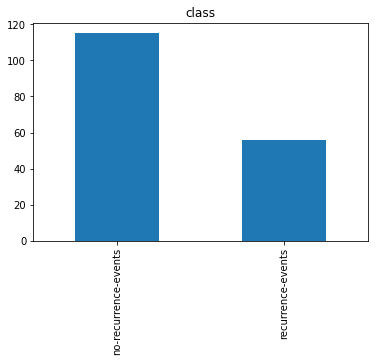

In [29]:
cancer_set_for_training90, cancer_testing90 = data_utils.data_split(cancer_dataset, 90)
cancer_training90, cancer_validation90 = data_utils.split_training_data_for_pruning(cancer_set_for_training90)
print(cancer_training90['CLASS'].value_counts())
cancer_training90['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

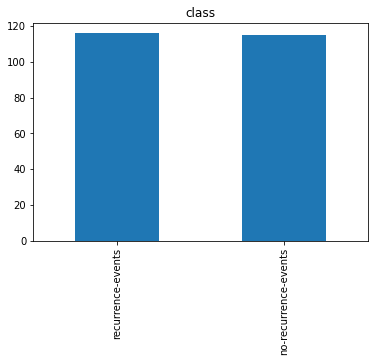

In [30]:

#Target for all 174
resampling_cancer90 = cancer_training90.copy()
recurrence_events_part90 = resampling_cancer90[resampling_cancer90['CLASS'] == 'recurrence-events']
no_recurrence_events_part90 = resampling_cancer90[resampling_cancer90['CLASS'] == 'no-recurrence-events'] 

recurrence_events_part_upsampled90 = resample(recurrence_events_part90, 
                                 replace=True,     
                                 n_samples=116)

# Combine majority class with upsamplet minority class
balanced_cnacer_training90 = pd.concat([recurrence_events_part_upsampled90, no_recurrence_events_part90])
balanced_cnacer_training90 = balanced_cnacer_training90.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_cnacer_training90 = balanced_cnacer_training90.sample(frac=1).reset_index(drop=True)

cancer_training90 = balanced_cnacer_training90.copy()
cancer_training90['CLASS'].value_counts().plot(kind='bar', title='class')

## Model Training

In [31]:
train_tree_for_different_heuristics(cancer_training70, cancer_testing70, cancer_validation70)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 66.28% | training 96.59% | levels 18 | leafs 48
After Pruning:
Accuracy for: testing 79.07% | training 72.73% | levels 14 | leafs 9


Before Pruning - heuristic = info_gain
Accuracy for: testing 59.30% | training 95.45% | levels 16 | leafs 45
After Pruning:
Accuracy for: testing 70.93% | training 72.73% | levels 16 | leafs 13


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 53.49% | training 92.61% | levels 18 | leafs 43
After Pruning:
Accuracy for: testing 76.74% | training 66.48% | levels 4 | leafs 3


Before Pruning - heuristic = distance_measure
Accuracy for: testing 46.51% | training 85.80% | levels 16 | leafs 41
After Pruning:
Accuracy for: testing 76.74% | training 52.27% | levels 2 | leafs 2


Before Pruning - heuristic = j_measure
Accuracy for: testing 59.30% | training 96.02% | levels 16 | leafs 43
After Pruning:
Accuracy for: testing 70.93% | training 72.73% | levels 16 | lea

In [32]:
train_tree_for_different_heuristics(cancer_training80, cancer_testing80, cancer_validation80)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 65.52% | training 91.58% | levels 16 | leafs 50
After Pruning:
Accuracy for: testing 79.31% | training 66.83% | levels 2 | leafs 2


Before Pruning - heuristic = info_gain
Accuracy for: testing 67.24% | training 95.54% | levels 18 | leafs 47
After Pruning:
Accuracy for: testing 75.86% | training 72.77% | levels 16 | leafs 14


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 60.34% | training 95.54% | levels 18 | leafs 46
After Pruning:
Accuracy for: testing 75.86% | training 66.83% | levels 4 | leafs 3


Before Pruning - heuristic = distance_measure
Accuracy for: testing 50.00% | training 84.16% | levels 18 | leafs 54
After Pruning:
Accuracy for: testing 63.79% | training 71.29% | levels 18 | leafs 23


Before Pruning - heuristic = j_measure
Accuracy for: testing 68.97% | training 95.05% | levels 18 | leafs 45
After Pruning:
Accuracy for: testing 75.86% | training 72.77% | levels 16 | le

In [33]:
train_tree_for_different_heuristics(cancer_training90, cancer_testing90, cancer_validation90)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 55.17% | training 90.48% | levels 18 | leafs 53
After Pruning:
Accuracy for: testing 65.52% | training 67.97% | levels 12 | leafs 9


Before Pruning - heuristic = info_gain
Accuracy for: testing 44.83% | training 91.34% | levels 18 | leafs 61
After Pruning:
Accuracy for: testing 55.17% | training 72.73% | levels 18 | leafs 15


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 51.72% | training 94.81% | levels 18 | leafs 47
After Pruning:
Accuracy for: testing 62.07% | training 68.83% | levels 12 | leafs 9


Before Pruning - heuristic = distance_measure
Accuracy for: testing 55.17% | training 78.79% | levels 18 | leafs 52
After Pruning:
Accuracy for: testing 68.97% | training 60.17% | levels 16 | leafs 12


Before Pruning - heuristic = j_measure
Accuracy for: testing 58.62% | training 91.77% | levels 18 | leafs 65
After Pruning:
Accuracy for: testing 68.97% | training 64.94% | levels 8 | l

# CMC Dataset

## Dataset preparation

In [34]:
cmc_dataset_path = 'data/cmc.data'
cmc_dataset_labels = ['age','education','husbandEducation','noChildren','religion','isWorking','husbandOccupation','livingStandard', 'mediaExposure', 'CLASS']
cmc_dataset = data_utils.preapare_dataset(cmc_dataset_path, cmc_dataset_labels)
# cmc_dataset['CLASS'] = cmc_dataset['CLASS'].apply(str)
# cmc_dataset.head()
cmc_dataset

,age,education,husbandEducation,noChildren,religion,isWorking,husbandOccupation,livingStandard,mediaExposure,CLASS
0,45,3,4,2,0,1,3,3,0,3
1,35,3,4,5,1,1,1,4,0,3
2,37,2,3,4,1,1,2,3,0,1
3,29,4,4,1,1,1,1,3,0,1
4,45,2,4,2,1,0,2,4,0,1
...,...,...,...,...,...,...,...,...,...,...
1468,32,3,3,6,1,0,3,3,0,2
1469,32,4,4,3,1,0,1,4,0,3
1470,43,1,3,2,1,0,2,2,1,1
1471,39,3,3,8,1,0,1,4,0,3


In [35]:
vals_to_replace_education = {1: 'low', 2:'medium', 3:'normal', 4:'high'}
vals_to_replace_husbandEducation = {1: 'low', 2:'medium', 3:'normal', 4:'high'}
vals_to_replace_religion = {0: 'Non-Islam', 1:'Islam'}
vals_to_replace_isWorking = {0: 'Yes', 1:'No'}
vals_to_replace_livingStandard= {1: 'low', 2:'medium', 3:'normal', 4:'high'}
vals_to_replace_mediaExposure = {0: 'Good', 1:'Not good'}
vals_to_replace_CLASS = {1: 'No-use', 2:'Long-term', 3: 'Short-term'}
cmc_dataset['education'] = cmc_dataset['education'].map(vals_to_replace_education)
cmc_dataset['husbandEducation'] = cmc_dataset['husbandEducation'].map(vals_to_replace_husbandEducation)
cmc_dataset['religion'] = cmc_dataset['religion'].map(vals_to_replace_religion)
cmc_dataset['isWorking'] = cmc_dataset['isWorking'].map(vals_to_replace_isWorking)
cmc_dataset['livingStandard'] = cmc_dataset['livingStandard'].map(vals_to_replace_livingStandard)
cmc_dataset['mediaExposure'] = cmc_dataset['mediaExposure'].map(vals_to_replace_mediaExposure)
cmc_dataset['CLASS'] = cmc_dataset['CLASS'].map(vals_to_replace_CLASS)

In [36]:
# cmc_dataset.head()
cmc_dataset

,age,education,husbandEducation,noChildren,religion,isWorking,husbandOccupation,livingStandard,mediaExposure,CLASS
0,45,normal,high,2,Non-Islam,No,3,normal,Good,Short-term
1,35,normal,high,5,Islam,No,1,high,Good,Short-term
2,37,medium,normal,4,Islam,No,2,normal,Good,No-use
3,29,high,high,1,Islam,No,1,normal,Good,No-use
4,45,medium,high,2,Islam,Yes,2,high,Good,No-use
...,...,...,...,...,...,...,...,...,...,...
1468,32,normal,normal,6,Islam,Yes,3,normal,Good,Long-term
1469,32,high,high,3,Islam,Yes,1,high,Good,Short-term
1470,43,low,normal,2,Islam,Yes,2,medium,Not good,No-use
1471,39,normal,normal,8,Islam,Yes,1,high,Good,Short-term


### Cmc 70%

No-use        280
Short-term    251
Long-term     156
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

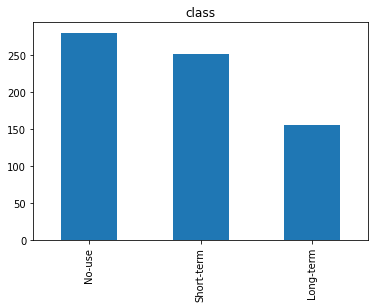

In [37]:
cmc_set_for_training70, cmc_testing70 = data_utils.data_split(cmc_dataset, 70)
cmc_training70, cmc_validation70 = data_utils.split_training_data_for_pruning(cmc_set_for_training70)
print(cmc_training70['CLASS'].value_counts())
#This data seems to be balanced so dont need aditional balancing
cmc_training70['CLASS'].value_counts().plot(kind='bar', title='class')

## Cmc 80%

No-use        320
Short-term    290
Long-term     175
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

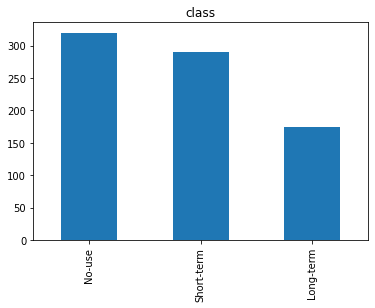

In [38]:
cmc_set_for_training80, cmc_testing80 = data_utils.data_split(cmc_dataset, 80)
cmc_training80, cmc_validation80 = data_utils.split_training_data_for_pruning(cmc_set_for_training80)
print(cmc_training80['CLASS'].value_counts())
#This data seems to be balanced so dont need aditional balancing
cmc_training80['CLASS'].value_counts().plot(kind='bar', title='class')

## Cmc 90%

No-use        370
Short-term    313
Long-term     200
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

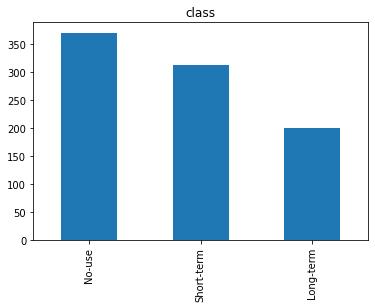

In [39]:
cmc_set_for_training90, cmc_testing90 = data_utils.data_split(cmc_dataset, 90)
cmc_training90, cmc_validation90 = data_utils.split_training_data_for_pruning(cmc_set_for_training90)
print(cmc_training90['CLASS'].value_counts())
#This data seems to be balanced so dont need aditional balancing
cmc_training90['CLASS'].value_counts().plot(kind='bar', title='class')

## Model Training

In [40]:
train_tree_for_different_heuristics(cmc_training70, cmc_testing70, cmc_validation70)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 48.42% | training 78.31% | levels 28 | leafs 172
After Pruning:
Accuracy for: testing 53.62% | training 63.32% | levels 26 | leafs 57


Before Pruning - heuristic = info_gain
Accuracy for: testing 40.50% | training 70.74% | levels 38 | leafs 179
After Pruning:
Accuracy for: testing 41.40% | training 41.34% | levels 8 | leafs 5


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 42.08% | training 71.03% | levels 38 | leafs 195
After Pruning:
Accuracy for: testing 45.70% | training 54.88% | levels 36 | leafs 93


Before Pruning - heuristic = distance_measure
Accuracy for: testing 34.62% | training 56.19% | levels 40 | leafs 172
After Pruning:
Accuracy for: testing 41.63% | training 40.76% | levels 2 | leafs 2


Before Pruning - heuristic = j_measure
Accuracy for: testing 38.69% | training 71.03% | levels 38 | leafs 181
After Pruning:
Accuracy for: testing 41.40% | training 41.34% | levels 8 

In [41]:
train_tree_for_different_heuristics(cmc_training80, cmc_testing80, cmc_validation80)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 50.51% | training 75.92% | levels 30 | leafs 175
After Pruning:
Accuracy for: testing 51.53% | training 63.18% | levels 28 | leafs 68


Before Pruning - heuristic = info_gain
Accuracy for: testing 39.32% | training 67.52% | levels 40 | leafs 185
After Pruning:
Accuracy for: testing 41.69% | training 52.10% | levels 36 | leafs 71


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 36.95% | training 68.03% | levels 40 | leafs 210
After Pruning:
Accuracy for: testing 43.39% | training 44.59% | levels 28 | leafs 35


Before Pruning - heuristic = distance_measure
Accuracy for: testing 42.37% | training 56.56% | levels 42 | leafs 175
After Pruning:
Accuracy for: testing 43.39% | training 40.76% | levels 2 | leafs 2


Before Pruning - heuristic = j_measure
Accuracy for: testing 41.02% | training 67.26% | levels 40 | leafs 184
After Pruning:
Accuracy for: testing 42.37% | training 44.33% | levels 

In [42]:

train_tree_for_different_heuristics(cmc_training90, cmc_testing90, cmc_validation90)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 47.30% | training 74.86% | levels 30 | leafs 174
After Pruning:
Accuracy for: testing 54.73% | training 60.93% | levels 22 | leafs 36


Before Pruning - heuristic = info_gain
Accuracy for: testing 42.57% | training 67.72% | levels 42 | leafs 190
After Pruning:
Accuracy for: testing 43.24% | training 52.10% | levels 42 | leafs 76


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 39.19% | training 68.18% | levels 42 | leafs 208
After Pruning:
Accuracy for: testing 39.86% | training 53.00% | levels 42 | leafs 92


Before Pruning - heuristic = distance_measure
Accuracy for: testing 37.84% | training 55.49% | levels 36 | leafs 191
After Pruning:
Accuracy for: testing 48.65% | training 45.98% | levels 28 | leafs 48


Before Pruning - heuristic = j_measure
Accuracy for: testing 42.57% | training 67.50% | levels 42 | leafs 189
After Pruning:
Accuracy for: testing 43.24% | training 52.10% | level

# Adult Dataset

## Data preparation

In [43]:
adult_dataset_path = 'data/adult.data'
adult_dataset_labels = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hourse-per-week','native-country','CLASS']
adult_dataset = data_utils.preapare_dataset(adult_dataset_path, adult_dataset_labels)
adult_dataset.head()
# adult_dataset

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hourse-per-week,native-country,CLASS
0,43,Private,143368,HS-grad,9,Divorced,Farming-fishing,Not-in-family,Black,Male,0,0,40,United-States,<=50K
1,40,Private,240504,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,United-States,>50K
2,28,Private,259840,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,>50K
3,17,?,241021,12th,8,Never-married,?,Own-child,Other,Female,0,0,40,United-States,<=50K
4,37,Private,191137,Assoc-acdm,12,Divorced,Prof-specialty,Unmarried,White,Male,0,0,25,United-States,<=50K


In [44]:
adult_dataset = adult_dataset[['age','workclass','education','education-num','marital-status','occupation','relationship','race','sex','hourse-per-week', 'native-country' ,'CLASS']]

for element in list(adult_dataset):
    if adult_dataset[element].dtype not in [np.float64, np.int64]:
        adult_dataset[element] = adult_dataset[element].str.strip()

adult_dataset['CLASS'] = adult_dataset['CLASS'].str.strip()
adult_dataset.head()
adult_dataset

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hourse-per-week,native-country,CLASS
0,43,Private,HS-grad,9,Divorced,Farming-fishing,Not-in-family,Black,Male,40,United-States,<=50K
1,40,Private,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,45,United-States,>50K
2,28,Private,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,60,United-States,>50K
3,17,?,12th,8,Never-married,?,Own-child,Other,Female,40,United-States,<=50K
4,37,Private,Assoc-acdm,12,Divorced,Prof-specialty,Unmarried,White,Male,25,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,44,Local-gov,Some-college,10,Never-married,Other-service,Own-child,Black,Male,40,United-States,<=50K
32557,37,Local-gov,Assoc-voc,11,Never-married,Other-service,Unmarried,Black,Female,32,United-States,<=50K
32558,21,Private,Some-college,10,Never-married,Exec-managerial,Not-in-family,White,Female,40,United-States,<=50K
32559,59,Private,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,40,United-States,<=50K


In [45]:
adult_dataset.dropna(how='any', axis=0)
indexNames = adult_dataset[(adult_dataset['workclass'] == '?') | (adult_dataset['education'] == '?') | (adult_dataset['marital-status'] == '?') | (adult_dataset['occupation'] == '?') | (adult_dataset['relationship'] == '?') | (adult_dataset['race'] == '?') | (adult_dataset['sex'] == '?') | (adult_dataset['native-country'] == '?') ].index
# print(indexNames)
adult_dataset.drop(indexNames, inplace=True)
adult_dataset.head()
adult_dataset.reset_index(inplace=True)
adult_dataset

,index,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hourse-per-week,native-country,CLASS
0,0,43,Private,HS-grad,9,Divorced,Farming-fishing,Not-in-family,Black,Male,40,United-States,<=50K
1,1,40,Private,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,45,United-States,>50K
2,2,28,Private,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,60,United-States,>50K
3,4,37,Private,Assoc-acdm,12,Divorced,Prof-specialty,Unmarried,White,Male,25,United-States,<=50K
4,5,17,Private,10th,6,Never-married,Handlers-cleaners,Own-child,White,Male,24,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30157,32556,44,Local-gov,Some-college,10,Never-married,Other-service,Own-child,Black,Male,40,United-States,<=50K
30158,32557,37,Local-gov,Assoc-voc,11,Never-married,Other-service,Unmarried,Black,Female,32,United-States,<=50K
30159,32558,21,Private,Some-college,10,Never-married,Exec-managerial,Not-in-family,White,Female,40,United-States,<=50K
30160,32559,59,Private,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,40,United-States,<=50K


In [46]:
# adult_dataset['education-num'].where(adult_dataset['education-num'] > 10)

### Adult 70%

<=50K    10573
>50K      3502
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

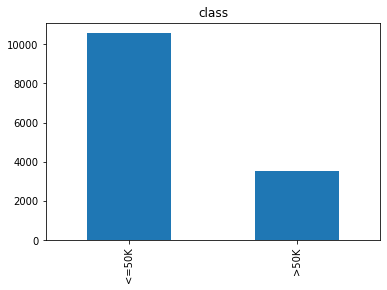

In [47]:
adult_set_for_training70, adult_testing70 = data_utils.data_split(adult_dataset, 70)
adult_training70, adult_validation70 = data_utils.split_training_data_for_pruning(adult_set_for_training70)

print(adult_training70['CLASS'].value_counts())
adult_training70['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

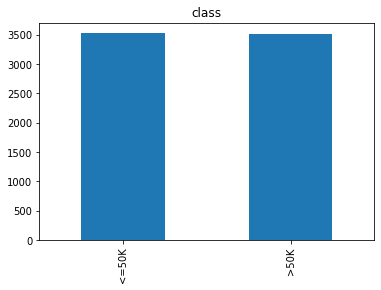

In [48]:
resampling_adult70 = adult_training70.copy()
less_50k_part70 = resampling_adult70[resampling_adult70['CLASS'] == '<=50K']
more_50k_part70 = resampling_adult70[resampling_adult70['CLASS'] == '>50K'] 

less_50k_part_downsampled70 = resample(less_50k_part70, 
                                 replace=False,    
                                 n_samples=3528)

# Combine minority class with downsampled majority class
balanced_adult_training70 = pd.concat([less_50k_part_downsampled70, more_50k_part70])
balanced_adult_training70 = balanced_adult_training70.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_adult_training70 = balanced_adult_training70.sample(frac=1).reset_index(drop=True)

adult_training70 = balanced_adult_training70.copy()
adult_training70['CLASS'].value_counts().plot(kind='bar', title='class')

### Adult 80%

<=50K    12079
>50K      4006
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

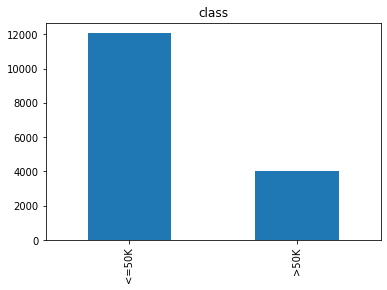

In [49]:
adult_set_for_training80, adult_testing80 = data_utils.data_split(adult_dataset, 80)
adult_training80, adult_validation80 = data_utils.split_training_data_for_pruning(adult_set_for_training80)

print(adult_training80['CLASS'].value_counts())
adult_training80['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

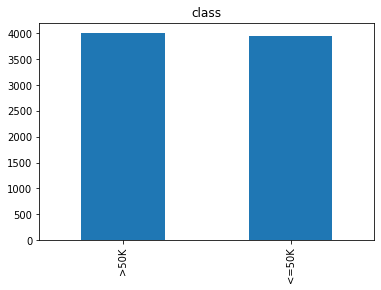

In [50]:
resampling_adult80 = adult_training80.copy()
less_50k_part80 = resampling_adult80[resampling_adult80['CLASS'] == '<=50K']
more_50k_part80 = resampling_adult80[resampling_adult80['CLASS'] == '>50K'] 

less_50k_part_downsampled80 = resample(less_50k_part80, 
                                 replace=False,    
                                 n_samples=3955)

# Combine minority class with downsampled majority class
balanced_adult_training80 = pd.concat([less_50k_part_downsampled80, more_50k_part80])
balanced_adult_training80 = balanced_adult_training80.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_adult_training80 = balanced_adult_training80.sample(frac=1).reset_index(drop=True)

adult_training80 = balanced_adult_training80.copy()
adult_training80['CLASS'].value_counts().plot(kind='bar', title='class')

### Adult 90%

<=50K    13569
>50K      4527
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

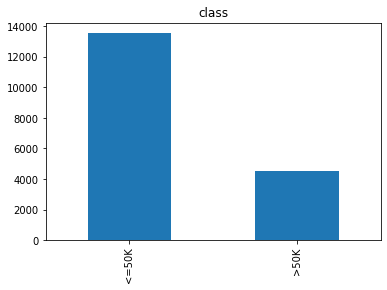

In [56]:
adult_set_for_training90, adult_testing90 = data_utils.data_split(adult_dataset, 90)
adult_training90, adult_validation90 = data_utils.split_training_data_for_pruning(adult_set_for_training90)

print(adult_training90['CLASS'].value_counts())
adult_training90['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

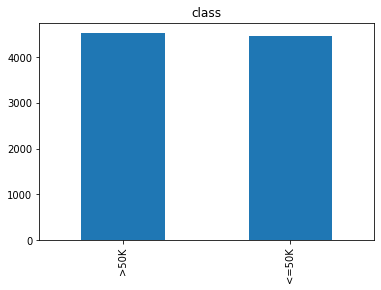

In [57]:
resampling_adult90 = adult_training90.copy()
less_50k_part90 = resampling_adult90[resampling_adult90['CLASS'] == '<=50K']
more_50k_part90 = resampling_adult90[resampling_adult90['CLASS'] == '>50K'] 

less_50k_part_downsampled90 = resample(less_50k_part90, 
                                 replace=False,    
                                 n_samples=4469)

# Combine minority class with downsampled majority class
balanced_adult_training90 = pd.concat([less_50k_part_downsampled90, more_50k_part90])
balanced_adult_training90 = balanced_adult_training90.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_adult_training90 = balanced_adult_training90.sample(frac=1).reset_index(drop=True)

adult_training90 = balanced_adult_training90.copy()
adult_training90['CLASS'].value_counts().plot(kind='bar', title='class')

## Model Training

In [53]:
train_tree_for_different_heuristics(adult_training70, adult_testing70, adult_validation70)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 73.69% | training 82.83% | levels 40 | leafs 211
After Pruning:
Accuracy for: testing 79.11% | training 79.33% | levels 40 | leafs 49


Before Pruning - heuristic = info_gain
Accuracy for: testing 75.32% | training 54.04% | levels 62 | leafs 276
After Pruning:
Accuracy for: testing 75.42% | training 50.18% | levels 2 | leafs 2


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 75.32% | training 53.71% | levels 62 | leafs 277
After Pruning:
Accuracy for: testing 75.42% | training 50.18% | levels 2 | leafs 2


Before Pruning - heuristic = distance_measure
Accuracy for: testing 70.44% | training 76.69% | levels 48 | leafs 224
After Pruning:
Accuracy for: testing 79.82% | training 73.64% | levels 42 | leafs 110


Before Pruning - heuristic = j_measure
Accuracy for: testing 75.32% | training 54.04% | levels 62 | leafs 276
After Pruning:
Accuracy for: testing 75.42% | training 50.18% | levels 2

In [54]:
train_tree_for_different_heuristics(adult_training80, adult_testing80, adult_validation80)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 74.47% | training 82.31% | levels 44 | leafs 215
After Pruning:
Accuracy for: testing 79.46% | training 79.00% | levels 34 | leafs 46


Before Pruning - heuristic = info_gain
Accuracy for: testing 74.84% | training 53.94% | levels 56 | leafs 276
After Pruning:
Accuracy for: testing 74.84% | training 53.94% | levels 56 | leafs 276


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 74.84% | training 53.52% | levels 56 | leafs 276
After Pruning:
Accuracy for: testing 74.84% | training 53.52% | levels 56 | leafs 276


Before Pruning - heuristic = distance_measure
Accuracy for: testing 69.29% | training 76.13% | levels 50 | leafs 190
After Pruning:
Accuracy for: testing 81.02% | training 72.54% | levels 44 | leafs 97


Before Pruning - heuristic = j_measure
Accuracy for: testing 74.84% | training 53.94% | levels 56 | leafs 276
After Pruning:
Accuracy for: testing 74.84% | training 53.94% | lev

In [58]:
train_tree_for_different_heuristics(adult_training90, adult_testing90, adult_validation90)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 75.24% | training 82.08% | levels 38 | leafs 224
After Pruning:
Accuracy for: testing 79.81% | training 78.90% | levels 38 | leafs 66


Before Pruning - heuristic = info_gain
Accuracy for: testing 75.34% | training 53.63% | levels 52 | leafs 272
After Pruning:
Accuracy for: testing 75.34% | training 53.63% | levels 52 | leafs 272


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 75.34% | training 53.22% | levels 52 | leafs 273
After Pruning:
Accuracy for: testing 75.34% | training 53.22% | levels 52 | leafs 273


Before Pruning - heuristic = distance_measure
Accuracy for: testing 73.45% | training 76.16% | levels 52 | leafs 243
After Pruning:
Accuracy for: testing 80.38% | training 71.42% | levels 44 | leafs 106


Before Pruning - heuristic = j_measure
Accuracy for: testing 75.34% | training 53.63% | levels 52 | leafs 272
After Pruning:
Accuracy for: testing 75.34% | training 53.63% | le